In [124]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.interpolate import CubicSpline, Akima1DInterpolator
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
from sklearn import linear_model
from tqdm.notebook import trange, tqdm
from pynverse import inversefunc
import scipy as sp
from matplotlib.widgets import Slider, Button
from joblib import Parallel, delayed 
import matplotlib.animation as animation


%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# Model

## Age model

In [2]:
def generate_X_linReg(Amp, freq, times):
    ts_cos = Amp[None]*np.sin(freq[None]*times[:,None])
    ts_sin = Amp[None]*np.cos(freq[None]*times[:,None])
    return np.concatenate([ts_cos, ts_sin], axis=1)

In [287]:
def linear_inverse_SR(x, a=4):
    """

    Args:
        x (depth): 
        a (slope) from [-2,2]
    
    Returns:
        linear inverse SR so that depth = 0 and 1 when time = 0 and 1
    """
    b = 1 - a/2
    return a*x + b  


def constant_inverse_SR(x):
    """

    Args:
        x (array): depth

    Returns:
        cosntant SR
    """
    return np.ones_like(x)

def sine_inverse_SR(x, A=0.2, k=2):
        
    inv_SR = A*np.cos(np.pi*k*x) + 1
    
    return inv_SR

def logistic_inverse_SR(x, A=0.4, k=20):
    """
    Args:
        x (_type_): depth
        A (float, optional): Range of the inverse SR. Defaults to 0.4.
        k (int, optional): steepness of the SR at depth=0.5. Defaults to 20.

    Returns:
        array of size x: logistic inverse SR (with average=1) so that  time = 0 and 1 when depth = 0 and 1 
    """
    return 1/(1+np.exp(-k*(x-0.5)))*A + (1-A/2)

def heart_wave_inverse_SR(x, A=0.2, k=5):
    """

    Args:
        x (_type_): depth
        A (float, optional): Amplitude. Defaults to 0.2.
        k (int, optional): number of peaks of the sine. Defaults to 5.

    Returns:
        array of size x: heart_wave_inverse_SR so that  time = 0 and 1 when depth = 0 and 1 
    """
    B = 1 - A/(2*np.pi*k)*(1-np.cos(k*np.pi))
    y =  A*np.sin(k*2*np.pi*(x-0.25)) + B
    a, b = np.searchsorted(x, [0.25, 0.75])
    y[:a] = np.ones_like(x[:a])*B
    y[b:] = np.ones_like(x[b:])*B
    return y

# def zigzag_inverse_SR(x, k=2):
#     knots = np.linspace(0,1,k+2)
#     np.piecewise(x, [ x < knots[i] for i in range(k+1)], [-1, 1])



Text(0.5, 0, 'depth')

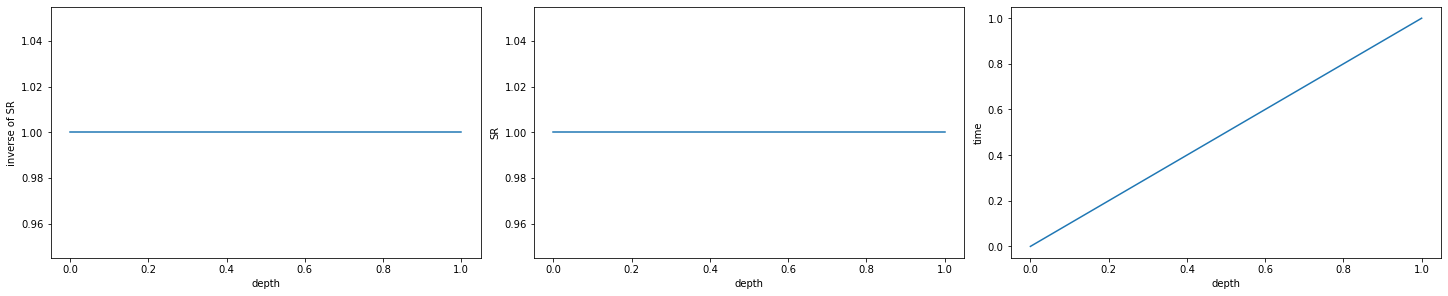

In [335]:
N_data = 1001
depth = np.linspace(0,1,N_data)
func_inv_SR = partial(sine_inverse_SR, A=0.3, k=3)
# func_inv_SR = partial(linear_inverse_SR, a=-1.2)
func_inv_SR = partial(logistic_inverse_SR, A=0.4, k=20)
# func_inv_SR = partial(heart_wave_inverse_SR, A=0.2, k=3)
func_inv_SR = constant_inverse_SR
invSR = func_inv_SR(depth)
SR = 1/invSR
time = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)

fig = plt.figure(figsize=(20,4), constrained_layout=True)
# fig.suptitle(f"{func_inv_SR.__name__}")
n = 3

plt.subplot(1,n,1)
plt.plot(depth, invSR)
plt.xlabel("depth")
plt.ylabel("inverse of SR")

plt.subplot(1,n,2)

plt.plot(depth, SR)
plt.xlabel("depth")
plt.ylabel("SR")


plt.subplot(1,n,3)
plt.plot(depth, time)
plt.ylabel("time")
plt.xlabel("depth")


# plt.subplot(1,n,4)
# plt.plot(time, depth)
# plt.xlabel("time")
# plt.ylabel("depth")




In [336]:
b_k = np.array([0.018986, 0.016354, 0.013055, 0.008849, 0.004248])/0.022
muy_k = np.array([4.257564, 7.456665, 17.910194, 17.366595, 5.579378])
phi_k = np.array([30.739, -157.801, 140.577, -55.885, 77.107])
p0 = 50.467718
muy_k = muy_k/180/3600*np.pi
muy_k = muy_k*1e6
p0 = p0/180/3600*np.pi
p0 = p0*1e6

phi_k = phi_k/180/3600*np.pi
phi_p = np.pi/2
# b_k
n_terms = 4
b_k = b_k[:n_terms]
muy_k = muy_k[:n_terms]
phi_k = phi_k[:n_terms]

In [337]:
phi_true = np.random.rand(n_terms)*np.pi
ABtrue = np.hstack([np.cos(phi_true), np.sin(phi_true)])
ABtrue = ABtrue*np.hstack([b_k,b_k])
X_true = generate_X_linReg(np.ones_like(muy_k), muy_k+p0, time)
# X = generate_X_linReg(b_k, muy_k+p0, time)

y_EP = X_true @ ABtrue
noise = np.random.randn(N_data)*1
y_model = y_EP
y = y_model + noise


Text(0.5, 0, 'depth')

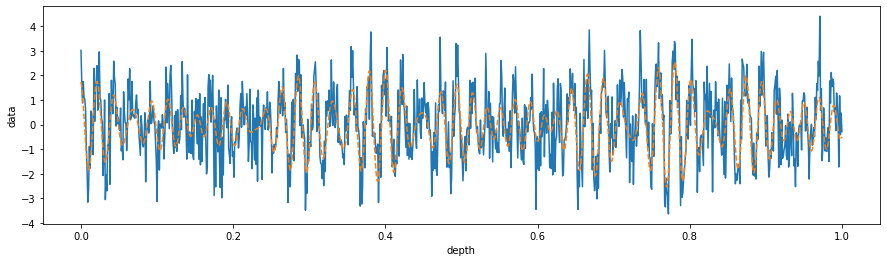

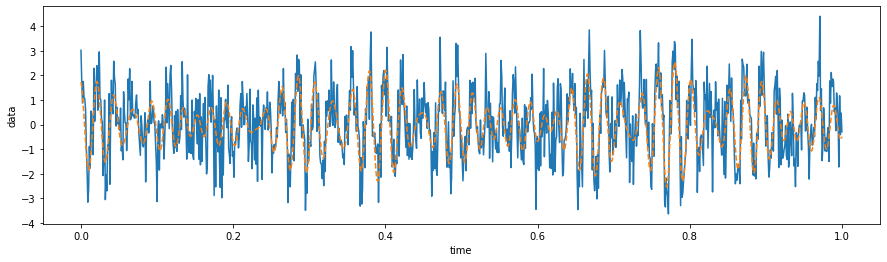

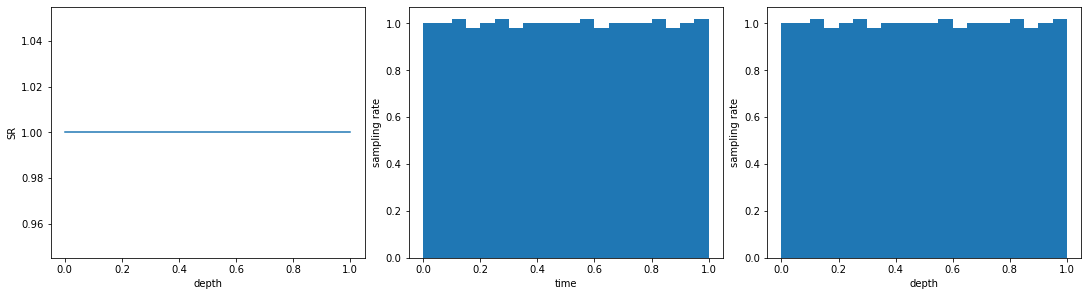

In [338]:
plt.figure(figsize=(15,4))
plt.plot(depth, y)
plt.plot(depth, y_model,'--')
plt.xlabel("depth")
plt.ylabel("data")
plt.figure(figsize=(15,4))
plt.plot(time, y)
plt.plot(time, y_model,'--')
# plt.scatter(time, np.ones_like(time)*-4, s=0.1, color="black")
plt.xlabel("time")
plt.ylabel("data")

fig = plt.figure(figsize=(15, 4), constrained_layout=True)
n = 3
plt.subplot(1,n,1)
plt.plot(depth, 1/invSR)
plt.ylabel("SR")
plt.xlabel("depth")
plt.subplot(1,n,2)
plt.hist(time, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("time")
plt.subplot(1,n,3)
plt.hist(depth, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("depth")

## Linear Regression

LR when SR is known

In [333]:
reg = linear_model.LinearRegression()
X = generate_X_linReg(np.ones_like(muy_k), muy_k+p0, time)
reg.fit(X, y)

print("score R2", reg.score(X,y))
print("AB")
print(ABtrue)
print(reg.coef_)
print("Amplitude")
print("True", ABtrue[:n_terms]**2+ABtrue[n_terms:]**2)
# print(b_k**2)
print("Pred", reg.coef_[:n_terms]**2+reg.coef_[n_terms:]**2)
# b_k**2
print("Phase")
print("True", np.arctan(ABtrue[n_terms:]/ABtrue[:n_terms])/(2*np.pi)*360)
print("Pred", np.arctan(reg.coef_[n_terms:]/reg.coef_[:n_terms])/(2*np.pi)*360)


score R2 0.4932682498504727
AB
[0.81632038 0.68393514 0.57117707 0.37604692 0.2799822  0.29124254
 0.16090712 0.14274275]
[0.82561946 0.73832201 0.59871423 0.31553424 0.27403513 0.25188493
 0.14686554 0.06998083]
Amplitude
True [0.744769   0.5525895  0.35213435 0.16178678]
Pred [0.75674274 0.60856541 0.38002822 0.10445918]
Phase
True [18.9309829  23.06593297 15.73313552 20.78614128]
Pred [18.36175747 18.83751856 13.78259935 12.50494436]


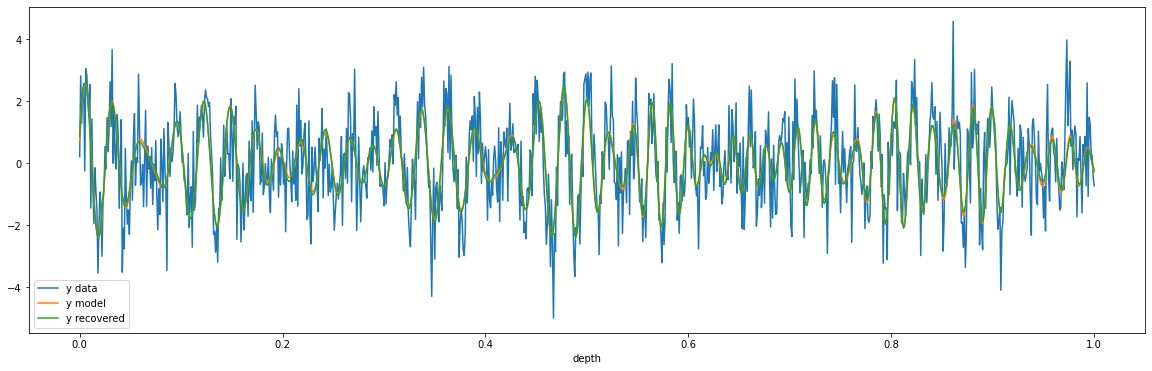

In [334]:
y_true = X @ ABtrue
y_pred = X @ reg.coef_

plt.figure(figsize=(20,6))
plt.plot(depth, y, label="y data")
plt.plot(depth, y_pred, label="y model")
plt.plot(depth, y_true, label="y recovered")
plt.xlabel("depth")
plt.legend()

LR when SR is assumed to be constant, when in fact it is not

[-0.11208644  0.10192269 -0.06754948 -0.3694933   0.10849331 -0.17125143
 -0.10312498  0.01118723]
[-0.6145703  -0.38115917 -0.59319617  0.3884057   0.60586495  0.63820622
  0.01589497  0.10453609]
Amplitude
True [0.744769   0.5525895  0.35213435 0.16178678]
Pred [0.02433417 0.03971529 0.01519769 0.13665045]
Phase
True [-44.59131685 -59.15286759  -1.53489986  15.06371923]
Pred [-44.0667634  -59.24041518  56.77418491  -1.73422675]


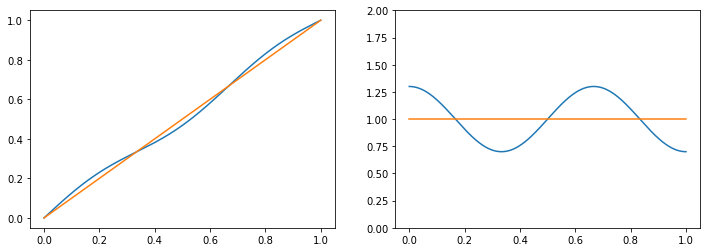

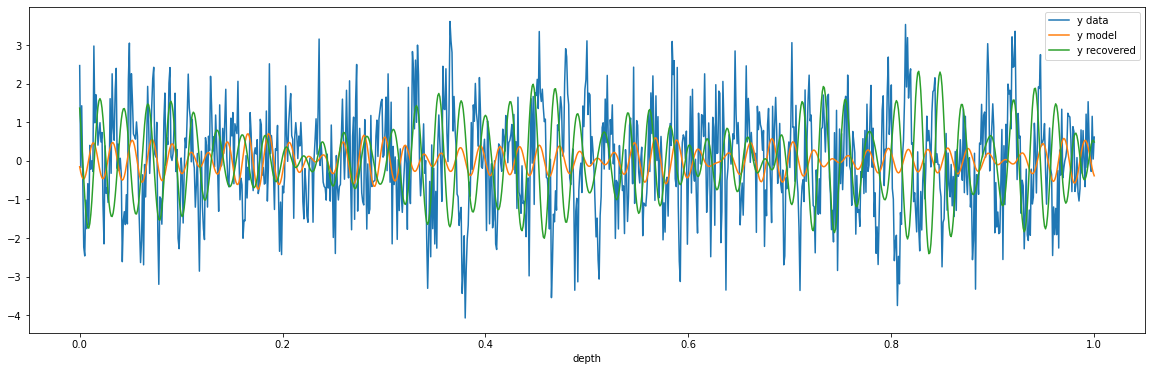

In [151]:
time_constant_SR = depth*1
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(depth, time)
plt.plot(depth, time_constant_SR)
plt.subplot(1,2,2)
plt.plot(depth, invSR)
plt.plot(depth, np.ones_like(depth))
plt.ylim([0,2])
reg = linear_model.LinearRegression()
X = generate_X_linReg(np.ones_like(muy_k), muy_k+p0, time_constant_SR)
reg.fit(X, y)
print(reg.coef_)
print(ABtrue)
print("Amplitude")
print("True", ABtrue[:n_terms]**2+ABtrue[n_terms:]**2)
# print(b_k**2)
print("Pred", reg.coef_[:n_terms]**2+reg.coef_[n_terms:]**2)
# b_k**2
print("Phase")
print("True", np.arctan(ABtrue[n_terms:]/ABtrue[:n_terms])/(2*np.pi)*360)
print("Pred", np.arctan(reg.coef_[n_terms:]/reg.coef_[:n_terms])/(2*np.pi)*360)



y_true = X @ ABtrue
y_pred = X @ reg.coef_

plt.figure(figsize=(20,6))
plt.plot(depth, y, label="y data")
plt.plot(depth, y_pred, label="y model")
plt.plot(depth, y_true, label="y recovered")
plt.xlabel("depth")
plt.legend()

# Genetic Algorithm (GA)

## Specification of operator

Metric and selection

In [8]:
def selection_tournament(fits, n, k=2, elitism=True):
    """
    input: fits - the fitness of the populations
           k - size of the tournament
           n - size of the selected individuals
    Randomly select k participants for the tournaments, pick the best amongst k participants
    Repeat n times the tournaments to obtain n winners
    If elitism is True: always retain the best individual
    output: indexes of n selected individuals by the tournament
    """
    inds = np.arange(len(fits))
    inds_tnm = np.random.choice(inds, (n,k))
    winner_results = np.argmax(fits[inds_tnm], 1)
    inds_winner =np.choose(winner_results, inds_tnm.T)
    if elitism:
        arg_best = np.argmax(fits)
        if arg_best not in inds_winner:
            inds_winner[np.random.choice(n)] = arg_best
    return inds_winner
selection_tournament(np.linspace(0,1,11), 10)

array([ 2,  8,  7,  9,  2,  9, 10,  6, 10,  7])

In [317]:
def interpolate_BSpline(SR, depth):
    spl_SR = splrep(*SR)
    SR_interpolate = splev(depth, spl_SR)
    return SR_interpolate

def interpolate_CubicSpline(SR, depth):
    spl_SR = CubicSpline(*SR)
    SR_interpolate = spl_SR(depth)
    return SR_interpolate
    
def interpolate_Akima(SR, depth):
    if len(SR[0]) == 2:
        slope = (SR[1,1]-SR[1,0])/(SR[0,1]-SR[0,0])
        SR_interpolate = slope*depth + SR[1,0]
    else:
        SR_interpolate = Akima1DInterpolator(SR[0],SR[1])(depth)
    return SR_interpolate

def metric(invSR, data, fs, interpolator=interpolate_CubicSpline, metric_type="BIC", *args, **kwargs):
    """_summary_: 
    
        metric  (according to the metric type) for the linear model with predictors variable are fourier harmonics of frequencies fs
        of fitting the data, when used the age model derived from the invSR.
        age model: given points of inverse SR, interpolate with an interpolator and integrate along depth
        to obtain time.
    Args:
        invSR (_type_): inverse of sedimetation rates and their corresponding depth 
        interpolator: interpolator
        data (_type_): the data and corresponding depth
        fs (_type_): list of frequencies of the model
        metric_type (str, optional):"BIC", "AIC" or "RSS". Defaults to "BIC".
            Returns:
        int: metric
           
    """

    depth, y_data = data

    invSR_interpolate = interpolator(invSR, depth)
    # invSR_interpolate[invSR_interpolate<0] = 0
    
    time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
    X = generate_X_linReg(np.ones_like(fs), fs, time)

    reg_model = LinearRegression().fit(X, y_data)
    # Residual Sum Square
    RSS = np.sum((y_data - reg_model.predict(X))**2)
    N = len(y_data)
    n_params_SR = len(invSR[0])
    n_params = n_params_SR + 1 + len(fs)*2 + 2 
    if metric_type == "BIC":
        coef = np.log(N)
    elif metric_type == "AIC":
        coef = 2
    elif metric_type == "RSS":
        coef = 0
    metric = N*np.log(RSS/N) + coef*n_params
    return metric
    

    
interpolator = interpolate_CubicSpline
def metric_pop(invSR, depth, data, fs, interpolator, metric_type="BIC", *args, **kwargs):
    return np.array([metric(invSR, depth, data, fs, interpolator, metric_type, *args, **kwargs) for SR in SRs]) 

# yp = np.gradient(t, depth[1]-depth[0])
metric([depth[::100], y[::100]], [depth, y], muy_k+p0, interpolator)

842.6647440750154

In [ ]:
depth

In [172]:
%lprun -f metric metric([depth[::100], y[::100]], [depth, y], muy_k+p0, interpolator)

Timer unit: 1e-09 s

Total time: 0.00534295 s
File: /tmp/ipykernel_1963069/1442845180.py
Function: metric at line 19

Line #      Hits         Time  Per Hit   % Time  Line Contents
    19                                           def metric(invSR, data, fs, interpolator=interpolate_CubicSpline, metric_type="BIC", *args, **kwargs):
    20                                               """_summary_: 
    21                                               
    22                                                   metric  (according to the metric type) for the linear model with predictors variable are fourier harmonics of frequencies fs
    23                                                   of fitting the data, when used the age model derived from the invSR.
    24                                                   age model: given points of inverse SR, interpolate with an interpolator and integrate along depth
    25                                                   to obtain time.
    26   

Crossover

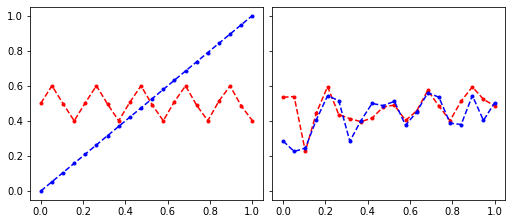

In [11]:
def crossover_blend(x1, x2, alpha=0.5, xrange=[0, 2]):
    """blend crossover between two array

    Args:
        x1 (n): chromosome/genotype 1 
        x2 (n): chromosome/geotype 2
        alpha (float, optional): _description_. Defaults to 0.5.

    Returns:
        two offsprings (y1(n), y2(n), each GENE (example: x1[0]) of each children is drawn randomly in the range
            [x1' - alpha*(x2'-x1'), x2' + alpha*(x2'-x1')]
            where x1',x2' = min(x1,x2), max(x1,x2)) 
    """
    assert len(x1) == len(x2)
    n = len(x1)
    x12 = np.vstack([x1,x2])
    min_x12 = np.min(x12, axis=0)
    max_x12 = np.max(x12, axis=0)
    range_x12 = max_x12-min_x12
    lower = np.max([min_x12-range_x12*alpha , np.ones(n)*xrange[0]],axis=0)
    upper = np.min([max_x12+range_x12*alpha , np.ones(n)*xrange[1]],axis=0)
    offsprings = [np.random.rand(n)*(upper - lower) + lower for _ in range(2)] 
    return offsprings

def crossover_pop(X, fits, crossover_operator=crossover_blend, *args, **kwargs):
    """_summary_
        Perform 2d 2-point crossover of 2 neighboring individuals in population 
        with probability pc = (fmax - f')/(fmax - <f>)        if f' >= <f>
                            = 1                             if f' <  <f>
        where   f' is the larger fitness of the two individuals
                fmax is the maximum fitness in the population
                <f> is the average fitness in the population
        Meaning:    All the individuals having fitness lower than average will be crossed, 
                    Those that good fitness are crossed less (to preserve good genes)
                    Population is crossed more when population getting stagnant (fmax is close to <f>)
                 
        Ref: Adaptive Probabilities of Crossover and Mutation (Srinivas and Patnaik 1994)
    Args:
        X (list[N_population][2, N_genes]): collection of individuals in the population
        metric_data (array[N_population]): metric mesures the fitness of individuals in the population
    Returns:
        _type_: _description_
    """
    fp = np.max(np.vstack([fits[::2],fits[1::2]]),axis=0)
    fmean = fits.mean(); fmax = fits.max()
    pc = np.ones(len(fp))
    eps = 1e-5
    pc[fp>=fmean] = (fmax-fp[fp>=fmean])/(fmax-fmean + eps) 
    for i in range(len(pc)):
        if np.random.rand() < pc[i]:
            X[i*2:i*2+2] = crossover_operator(X[i*2], X[i*2+1], *args, **kwargs)
    return X

# def crossover_blend_pop(X, metric_data):
#     metric_m = np.min( np.vstack([metric_data[::2],metric_data[1::2]]),axis=0)
#     metric_mean = metric_data.mean(); metric_min=metric_data.min()
#     pc = np.ones(len(metric_m))
#     eps =1e-5
#     pc[metric_m<=metric_mean] = (metric_m[metric_m<=metric_mean]-metric_min)/(metric_mean-metric_min + eps) 
#     Xx = X.copy()
#     for i in range(len(pc)):
#         if np.random.rand() < pc[i]:
#             Xx[i*2:i*2+2] = np.array(crossover_blend(Xx[i*2],Xx[i*2+1]))
#     return Xx

# TEST crossover_blended
x = np.linspace(0,1,20)
x1 = np.sin(30*x)*0.1+0.5
x2 = x*1
# x2 = np.ones_like(x)
# x2 = np.cos(10*x)+1
x1_x, x2_x = crossover_blend(x1, x2, 0.5, [0.2,0.6])
fig, axs =plt.subplots(1,2,figsize=(7,3),sharey=True,constrained_layout=True)
axs[0].plot(x,x1, "--.r")
axs[0].plot(x,x2, "--.b")
axs[1].plot(x,x1_x, "--.r")
axs[1].plot(x,x2_x, "--.b")
# axs[1].plot(x1_x[0],x1_x[1], "r--", x2_x[0], x2_x[1], "b--")




Mutation

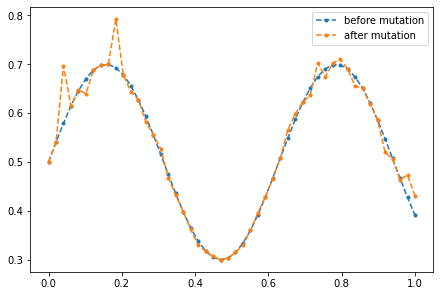

In [331]:
def mutation_poly(x1, pm, xrange=[0,1], eta=50):
    """
    Polynomial Mutation (Deb and Deb 2014)
    input: x1(n, ) is a chromosome containg n genes
    pm is probability of mutation for each  genes
    output: new x1
    """
    x1_m = x1.copy()
    n = len(x1)
    bool_m = np.random.rand(n) < pm
    arg_m  = np.argwhere(bool_m)[:,0]
    u = np.random.rand(len(arg_m))
    arg_m_L = arg_m[u<=0.5]
    arg_m_R = arg_m[u>0.5]
    delta_L = (2*u[u<=0.5])**(1/(1+eta))-1
    delta_R = 1-(2*(1-u[u>0.5]))**(1/(1+eta))
    x1_m[arg_m_L] = x1_m[arg_m_L] + delta_L*(x1_m[arg_m_L] - xrange[0])
    x1_m[arg_m_R] = x1_m[arg_m_R] + delta_R*(-x1_m[arg_m_R] + xrange[1])
    return x1_m

def mutation_poly_pop(X, metric_X, xrange=[0,1], eta=50):
    metric_mean = metric_X.mean(); metric_min=metric_X.min()
    pm = np.ones(len(metric_X))*0.5
    eps=1e-5
    pm[metric_X<=metric_mean] = (metric_X[metric_X<=metric_mean]-metric_min)/(metric_mean-metric_min + eps)*0.5
#     print(pm)
    Xm = np.array([mutation_poly(X[i], pm[i], xrange, eta) for i in range(len(X))])
    return Xm

def mutation_pop(X, fits, mutation_operator=mutation_poly, *arg, **kwargs):
    """_summary_
        Perform mutation_v2 for each individual in the population X
        with probability pm = (fmax - f')/(fmax - <f>)        if f' >= <f>
                            = 1                             if f' <  <f>
        where   f' is the larger fitness of the two individuals
                fmax is the maximum fitness in the population
                <f> is the average fitness in the population
        Meaning:    All the individuals having fitness lower than average will be crossed, 
                    Those that good fitness are crossed less (to preserve good genes)
                    Population is crossed more when population getting stagnant (fmax is close to <f>)
                 
        Ref: Adaptive Probabilities of Crossover and Mutation (Srinivas and Patnaik 1994)
    Args:
        X (list[N_population][2, N_genes]): collection of individuals in the population
        metric_data (array[N_population]): metric mesures the fitness of individuals in the population
    Returns:
        _type_: _description_
    """
    
    fmean = fits.mean(); fmax=fits.max()
    pm = np.ones(len(fits))*0.5
    eps=1e-5
    pm[fits>=fmean] = 0.5*(fmax - fits[fits>=fmean]) / (fmax - fmean + eps) 
#     print(pm)
    Xm = [mutation_operator(X[i], pm[i], *arg, **kwargs) for i in range(len(X))]
    return Xm
#TEST 1
# x = np.linspace(0,1,50)
# x1 = np.vstack([x,np.sin(10*x)])
# x1_x = mutation(x1, 0.5, yrange=[-1,1])
# plt.plot(x1[0],x1[1])
# plt.plot(x1_x[0],x1_x[1],'.')


# TEST mutation_poly
# x = np.linspace(0,1,50)
# x1 = np.sin(10*x)*0.2+0.5
# x1_x = mutation_poly(x1, 0.9, xrange=[0,2], eta=50)
# plt.plot(x, x1)
# plt.plot(x, x1_x)
# plt.plot(x, x1-x1_x)
# plt.plot(x1_x[0],x1_x[1])

#TEST mutation_poly_pop
plt.figure(constrained_layout=True)
x = np.linspace(0,1,50)
x1 = np.sin(10*x)*0.2+0.5
X = np.vstack([x1,x1,x1,x1])
X_x = mutation_pop(X, np.array([0,1,1,1]), xrange=[0,2], eta=50)
plt.plot(x, x1,'.--', label="before mutation")
plt.plot(x, X_x[0],'.--', label="after mutation")
plt.legend()
plt.savefig("figures/mutation.png",dpi=200)
# plt.plot(x, X_x[1],'.--')

# In action

## Problem

In [448]:
np.random.seed(126)
"Generate an age model"
N_data = 1001
depth = np.linspace(0,1,N_data)
func_inv_SR = partial(sine_inverse_SR, A=0.3, k=4)
# func_inv_SR = partial(linear_inverse_SR, a=-1.2)
# func_inv_SR = partial(logistic_inverse_SR, A=0.4, k=50)
func_inv_SR = partial(heart_wave_inverse_SR, A=0.2, k=5)
# func_inv_SR = constant_inverse_SR
invSR = func_inv_SR(depth)
SR = 1/invSR
time = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)

"""Generate an data"""

"EP model"
phi_true = np.random.rand(n_terms)*np.pi
ABtrue = np.hstack([np.cos(phi_true), np.sin(phi_true)])
ABtrue = ABtrue*np.hstack([b_k,b_k])
fs = muy_k + p0
X_true = generate_X_linReg(np.ones_like(muy_k), fs, time)

y_EP = X_true @ ABtrue
noise = np.random.randn(N_data)*1
y_model = y_EP
y = y_model + noise

# "simple model"
# f1 = 100; f2= 4.3*100
# A1 = 1; A2 = 1.2
# y_model = A1*np.cos(f1*time) + A2*np.cos(f2*time)
# fs =  np.array([f1, f2])
# y = y_model + noise


Text(0.5, 0, 'depth')

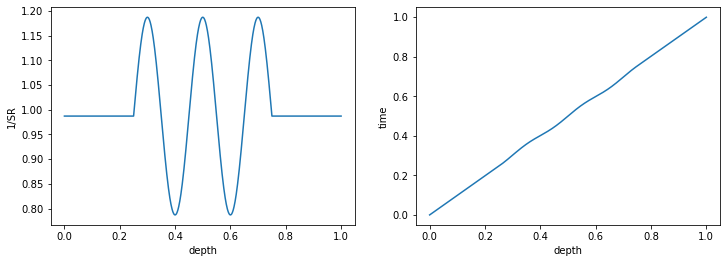

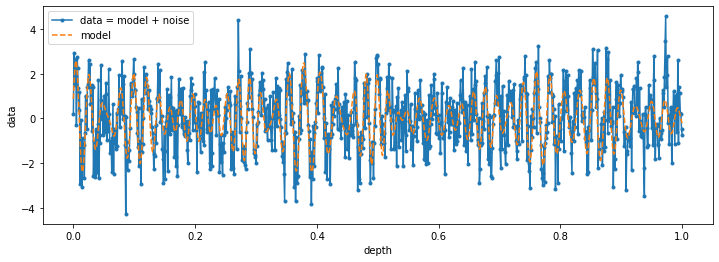

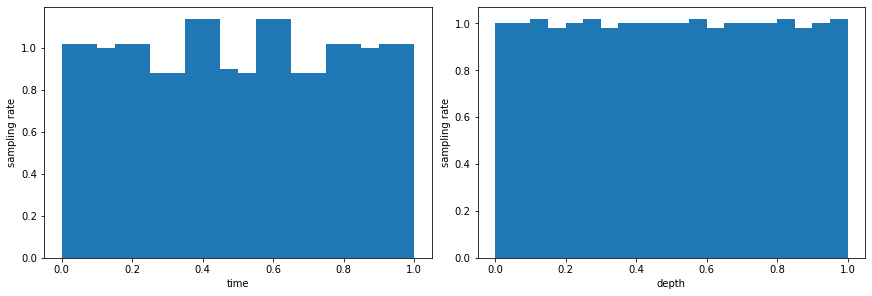

In [449]:
"plot"
# plt.subplots(1,2)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(depth, invSR)
plt.xlabel("depth")
plt.ylabel("1/SR")
plt.subplot(1,2,2)
plt.xlabel("depth")
plt.ylabel("time")
plt.plot(depth, time)
# plt.savefig("figures/timedepth_sinek8.png",dpi=200)


plt.figure(figsize=(12,4))
plt.plot(depth, y, '.-', label="data = model + noise")
plt.plot(depth, y_model,'--', label="model")
plt.xlabel("depth")
plt.ylabel("data")
plt.legend()
# plt.savefig("figures/data_sinek8.png",dpi=200)
# plt.figure(figsize=(15,4))
# plt.plot(time, y)
# plt.plot(time, y_model,'--')
# plt.scatter(time, np.ones_like(time)*-4, s=0.1, color="black")
# plt.xlabel("time")
# plt.ylabel("data")

fig = plt.figure(figsize=(12, 4), constrained_layout=True)
n = 2
plt.subplot(1,n,1)
plt.hist(time, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("time")
plt.subplot(1,n,2)
plt.hist(depth, bins=20, density=True)
plt.ylabel("sampling rate")
plt.xlabel("depth")

## Search

In [462]:
N_population = 500 # number of individual in population 
N_generations_max = 100
N_genes = 12# number of intial gene in an individial of the population 
# depth_grid = np.linspace(0,1,N_genes)
depth_grid = np.hstack([0, 0.15, 0.25, np.linspace(0.3,0.7,N_genes-6), 0.75, 0.85, 1.0])
# depth_grid = 0.5 + 0.5*np.cos((2*(np.arange(N_genes)+1)-1)/(2*N_genes)*np.pi); depth_grid = depth_grid[::-1]  #Chebysev nodes
invSR_lims = [0, 2]
fs = muy_k + p0
# fs =  np.array([f1, f2])
interpolator = interpolate_Akima
# interpolator = interpolate_CubicSpline
metric_min = metric([depth_grid, func_inv_SR(depth_grid)], [depth, y], fs, interpolator, metric_type="BIC")
print(metric_min)
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_grid, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini

286.87002439925897


In [463]:

def GA_search(data, fs, interpolator, N_population, N_generations_max, N_genes, invSR_lims):
    # eps = 1e-4
    
    depth_grid = np.linspace(0,1,N_genes)
    depth_grid = np.hstack([0, 0.15, 0.25, np.linspace(0.3,0.7,N_genes-6), 0.75, 0.85, 1.0])

    invSR_all = np.zeros((N_generations_max,N_population,N_genes))
    invSR_ini = np.random.rand(N_population,N_genes)*invSR_lims[1]
    invSR_all[0] = invSR_ini
    metric_all = np.zeros((N_generations_max,N_population))
    metric0 = partial(metric, data=data, fs=fs, interpolator=interpolator, metric_type="BIC")
    metric_ini = np.array([metric0([depth_grid, invSR_ini_i]) for invSR_ini_i in invSR_ini])
    metric_all[0] = metric_ini
    n_generations = N_generations_max
    for i in range(N_generations_max-1):
    #     print(i)
        invSR_i = invSR_all[i]
        metric_i = metric_all[i]
        if metric_i.min() ==  metric_i.max():
            n_generations = i+1
            break
        selected_inds = selection_tournament(-metric_i, N_population, 2, elitism=True)
        invSR_ip = crossover_pop(invSR_i[selected_inds], -metric_i[selected_inds], crossover_operator=crossover_blend)
        metric_ip = np.array([metric0([depth_grid, invSR_i_j]) for invSR_i_j in invSR_ip])
        # metric_ip = metric_all[i]
        invSR_ip = mutation_pop(invSR_ip, -metric_ip, mutation_operator=mutation_poly, xrange=invSR_lims, eta=20)
        metric_ip = np.array([metric0([depth_grid, invSR_i_j]) for invSR_i_j in invSR_ip])
        metric_all[i+1] = metric_ip
        invSR_all[i+1] = invSR_ip
    print(n_generations)
    metric_all = metric_all[:n_generations]
    invSR_all = invSR_all[:n_generations]
    return invSR_all, metric_all 

# GA_search()

kwargs = {
    "data": [depth, y],
    "fs" : fs,
    "interpolator":interpolator,
    "N_population":N_population,
    "N_generations_max":N_generations_max,
    "N_genes":N_genes,
    "invSR_lims":invSR_lims
}

GA_search_data = partial(GA_search,  **kwargs)
n_jobs = 100
res = Parallel(n_jobs=n_jobs, verbose=100)(delayed(GA_search_data)() for _ in range(n_jobs))
invSR_all_para = [item[0] for item in res]
metric_para = [item[1] for item in res]

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
22
[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:   23.8s
21
22
[Parallel(n_jobs=100)]: Done   3 out of 100 | elapsed:   24.8s remaining: 13.4min
18
21
[Parallel(n_jobs=100)]: Done   5 out of 100 | elapsed:   35.1s remaining: 11.1min
22
33
[Parallel(n_jobs=100)]: Done   7 out of 100 | elapsed:   36.8s remaining:  8.1min
26
33
[Parallel(n_jobs=100)]: Done   9 out of 100 | elapsed:   39.4s remaining:  6.6min
25
40
[Parallel(n_jobs=100)]: Done  11 out of 100 | elapsed:   42.9s remaining:  5.8min
32
30
[Parallel(n_jobs=100)]: Done  13 out of 100 | elapsed:   47.0s remaining:  5.2min
28
29
[Parallel(n_jobs=100)]: Done  15 out of 100 | elapsed:   48.0s remaining:  4.5min
45
45
[Parallel(n_jobs=100)]: Done  17 out of 100 | elapsed:   49.4s remaining:  4.0min
46
43
[Parallel(n_jobs=100)]: Done  19 out of 100 | elapsed:   55.7s remaining:  4.0min
51
48
[Parallel(n_jobs=100)]: Done  21 out of 100 | elapsed:  1

#  Result

## One population study

In [465]:
interpolator

<function __main__.interpolate_Akima(SR, depth)>

In [105]:
i_pop = 1
invSR_all = invSR_all_para[i_pop]
metric_all = metric_para[i_pop]
n_gen, n_pop, n_genes = invSR_all.shape
invSR_all_interpolate = np.zeros((n_gen, n_pop, len(depth)))
for i in range(n_gen):
    for j in range(n_pop):
        invSR_all_interpolate[i,j] = interpolator([depth_grid, invSR_all[i,j]], depth)
# invSR_all_interpolate = np.array([[interpolator([depth_grid, invSR_all[i,j]),] ])

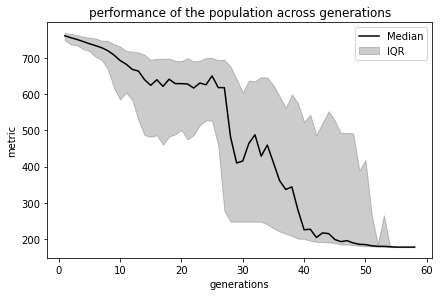

In [143]:
inds_generation = np.arange(1,n_gen+1)
# plt.plot(inds_generation, metric_all.mean(axis=1))
# plt.plot(inds_generation, metric_all.max(axis=1))
# plt.plot(inds_generation, metric_all.min(axis=1))
quantile_range = [0.25, 0.75]
metric_lo_up = np.quantile(metric_all, quantile_range, axis=1)
fig = plt.figure(constrained_layout=True)
plt.title("performance of the population across generations")
plt.plot(inds_generation, np.median(metric_all, axis=1), zorder=10,color="black", label="Median")
plt.fill_between(inds_generation, *metric_lo_up, alpha=0.2, color="black", label="IQR")
plt.xlabel("generations")
plt.ylabel("metric")
plt.legend()
plt.savefig("figures/metric_pop.png", dpi=200)

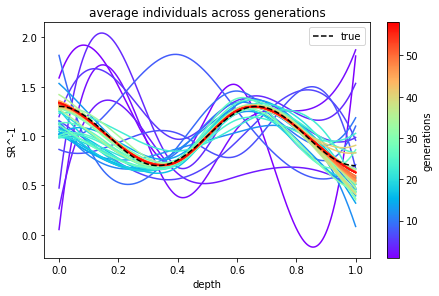

In [145]:
metric_all.shape
fig = plt.figure(constrained_layout=True)
cmap = plt.get_cmap("rainbow")
for i in range(n_gen):
# for i in range(20, 50):
    arg_best = np.argmin(metric_all[i])
    arg_med = np.argsort(metric_all[i])[n_pop//2]
    plt.plot(depth, invSR_all_interpolate[i, arg_med], color=cmap(i/n_gen))
plt.plot(depth, invSR, "--", color="black", label="true")
# plt.xlim([0,1])
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.title("average individuals across generations")
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(1,n_gen), cmap=cmap), label="generations")
plt.savefig("figures/invSR_average.png", dpi=200)
plt.legend()
# plt.colorbar(cmap)
# plt.savefig("figure")

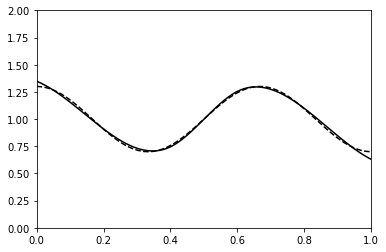

In [103]:
fig = plt.figure() # initialise la figure
line1, = plt.plot([], [], color="black") 
line2, = plt.plot([], [], "--", color="black") 
plt.xlim(0, 1)
plt.ylim(0, 2)
args_best = np.argmin(metric_all, axis=1)
def animate(i): 
    arg_best = np.argmin(metric_all[i])
    arg_med = np.argsort(metric_all[i])[n_pop//2]
    line2.set_data(depth, invSR)
    line1.set_data(depth, invSR_all_interpolate[i,arg_med])
    return line2, line1,
 
ani = animation.FuncAnimation(fig, animate, frames=n_gen, blit=False, interval=200, repeat=True)
ani.save("animation.mp4", dpi=200) 
# ani.savSD
# plt.show()

## Multiple-population

In [466]:
interpolator = interpolate_CubicSpline

In [410]:
def plot_MPGA(invSR_all_para, metric_para):
    metric_last = np.array([metric_para[i][-1] for i in range(100)])
    metric_best = metric_last.min(axis=1)
    # invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
    invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1,np.argmin(metric_last[i])]], depth) for i, invSR_all in enumerate(invSR_all_para)])
    # invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

    invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
    mean_invSR = np.median(invSR_interpolate_par,axis=0)
    invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.25, 0.75],axis=0)


    fig1 = plt.figure(constrained_layout=True)
    plt.title("estimation from 100 populations")
    plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
    plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
    plt.plot(depth, invSR, "--", color="black", label="true")
    plt.xlabel("depth")
    plt.ylabel("SR^-1")
    plt.legend()
    # plt.savefig("figures/invSR_all_populations_line.png", dpi=200)

    fig2 = plt.figure(constrained_layout=True)
    [plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
    plt.plot(depth, invSR, "--", color="black")
    plt.xlabel("depth")
    plt.ylabel("SR^-1")

    fig3 = plt.figure(constrained_layout=True)
    plt.hist(metric_best, color="black")
    plt.xlabel("metric")
    plt.ylabel("# population")
    return fig1, fig2, fig3

Line

Text(0, 0.5, 'SR^-1')

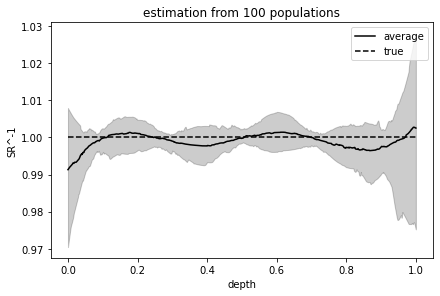

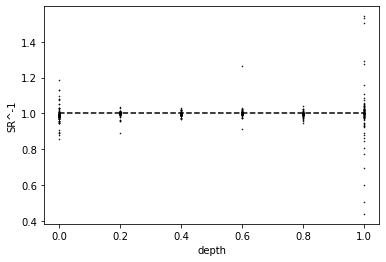

In [163]:
invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.2, 0.8],axis=0)

fig = plt.figure(constrained_layout=True)
plt.title("estimation from 100 populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="black", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
plt.savefig("figures/invSR_all_populations_line.png", dpi=200)

plt.figure() 
[plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
plt.plot(depth, invSR, "--", color="black")
plt.xlabel("depth")
plt.ylabel("SR^-1")
# plt.figure()
# plt.plot(depth, invSR, zorder=1000)
# for i in range(10):
#     # plt.plot(depth_grid, invSR_all_para[i][-1][0], '.')
#     plt.plot(depth, invSR_interpolate_par[i])


Text(0, 0.5, 'SR^-1')

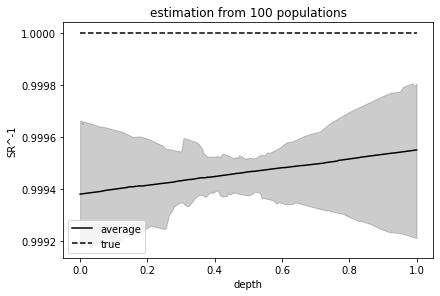

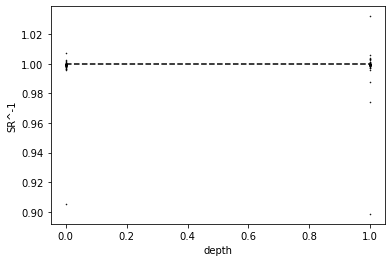

In [169]:
invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.2, 0.8],axis=0)

fig = plt.figure(constrained_layout=True)
plt.title("estimation from 100 populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="black", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
plt.savefig("figures/invSR_all_populations_line.png", dpi=200)

plt.figure() 
[plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
plt.plot(depth, invSR, "--", color="black")
plt.xlabel("depth")
plt.ylabel("SR^-1")
# plt.figure()
# plt.plot(depth, invSR, zorder=1000)
# for i in range(10):
#     # plt.plot(depth_grid, invSR_all_para[i][-1][0], '.')
#     plt.plot(depth, invSR_interpolate_par[i])


Text(0, 0.5, '# population')

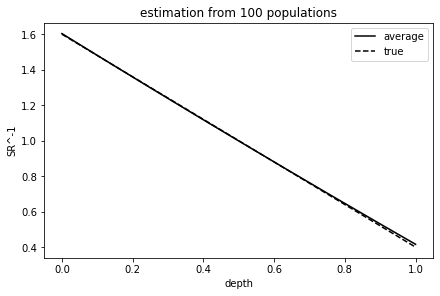

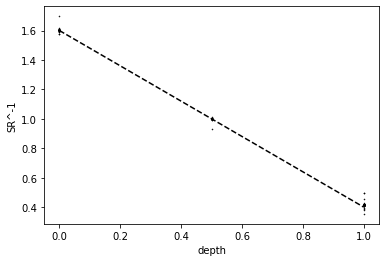

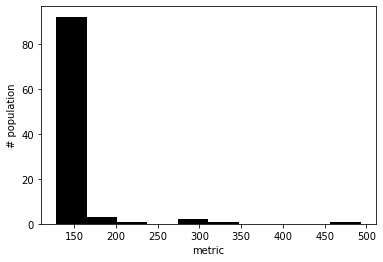

In [262]:
metric_last = np.array([metric_para[i][-1] for i in range(100)])
metric_best = metric_last.min(axis=1)
# invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1,np.argmin(metric_last[i])]], depth) for i, invSR_all in enumerate(invSR_all_para)])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.25, 0.75],axis=0)

fig = plt.figure(constrained_layout=True)
plt.title("estimation from 100 populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="black", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
# plt.savefig("figures/invSR_all_populations_line.png", dpi=200)

plt.figure() 
[plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
plt.plot(depth, invSR, "--", color="black")
plt.xlabel("depth")
plt.ylabel("SR^-1")

plt.figure() 
plt.hist(metric_best, color="black")
plt.xlabel("metric")
plt.ylabel("# population")



In [276]:
def plot_MPGA(invSR_all_para, metric_para):
    metric_last = np.array([metric_para[i][-1] for i in range(100)])
    metric_best = metric_last.min(axis=1)
    # invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
    invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1,np.argmin(metric_last[i])]], depth) for i, invSR_all in enumerate(invSR_all_para)])
    # invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

    invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
    mean_invSR = np.median(invSR_interpolate_par,axis=0)
    invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.05, 0.95],axis=0)


    fig = plt.figure(constrained_layout=True)
    plt.title("estimation from 100 populations")
    plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
    plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
    plt.plot(depth, invSR, "--", color="red", label="true")
    plt.xlabel("depth")
    plt.ylabel("SR^-1")
    plt.legend()
    # plt.savefig("figures/invSR_all_populations_line.png", dpi=200)

    plt.figure() 
    [plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
    plt.plot(depth, invSR, "--", color="black")
    plt.xlabel("depth")
    plt.ylabel("SR^-1")

    plt.figure() 
    plt.hist(metric_best, color="black")
    plt.xlabel("metric")
    plt.ylabel("# population")
    return fig

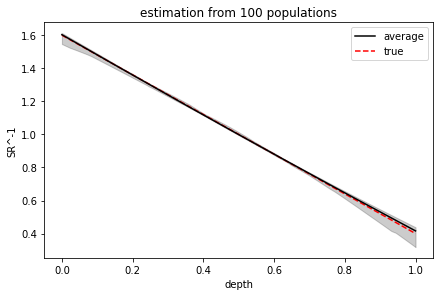

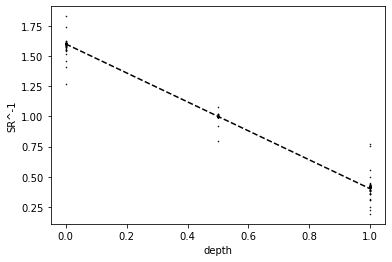

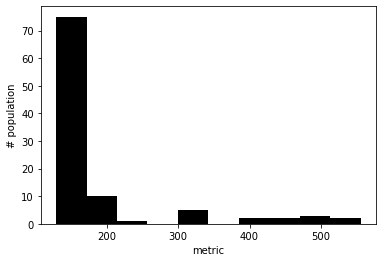

In [277]:
fig = plot_MPGA(invSR_all_para, metric_para)
fig.savefig("figures/test.png", dpi=200)

Sigmoid

In [299]:
fig.axes

[<AxesSubplot:title={'center':'estimation from 100 populations'}, xlabel='depth', ylabel='SR^-1'>]

(0.5, 1.5)

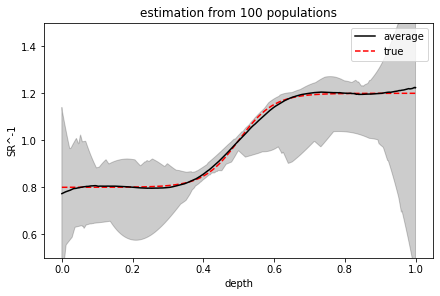

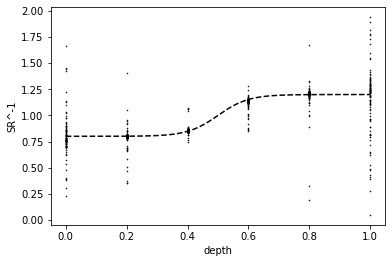

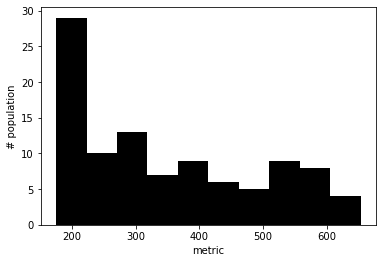

In [300]:
fig = plot_MPGA(invSR_all_para, metric_para)
fig.axes[0].set_ylim([0.5,1.5])

(0.6, 1.4)

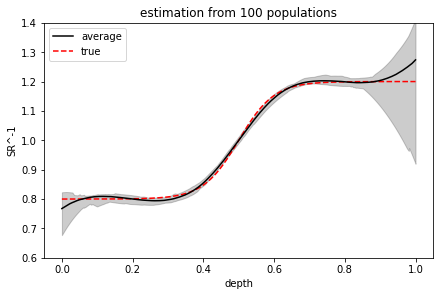

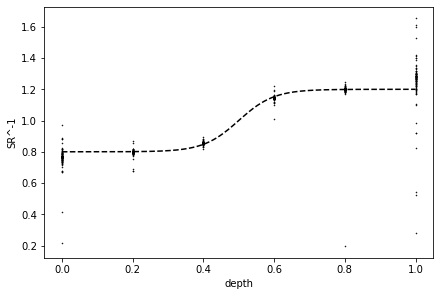

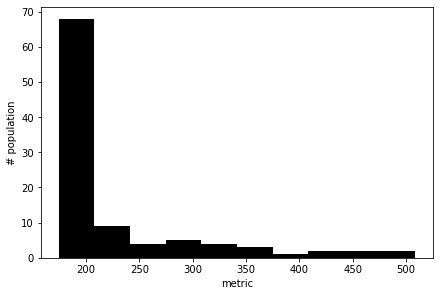

In [306]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
fig.axes[0].set_ylim([0.6,1.4])

(0.6, 1.4)

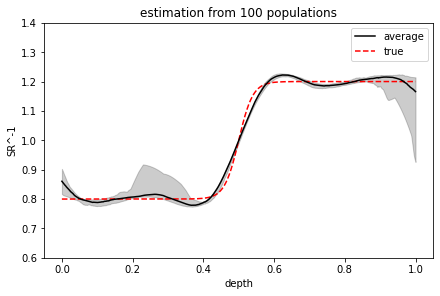

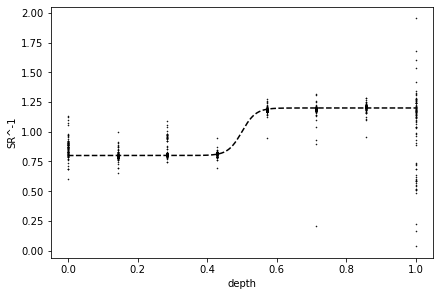

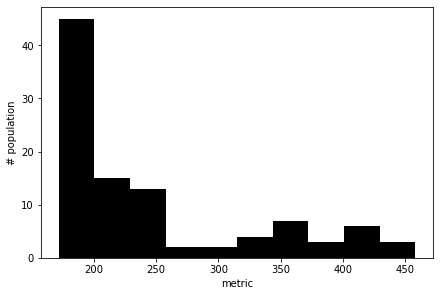

In [344]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
fig.axes[0].set_ylim([0.6,1.4])

Text(0, 0.5, '# population')

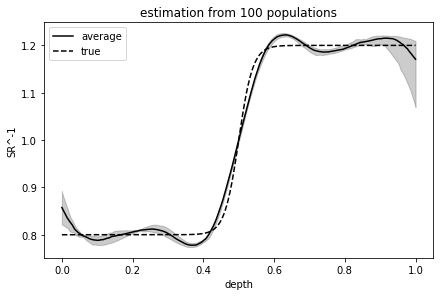

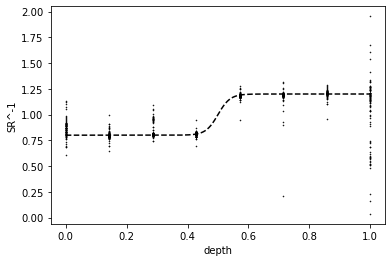

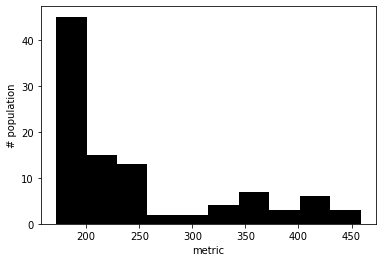

In [350]:
metric_last = np.array([metric_para[i][-1] for i in range(100)])
metric_best = metric_last.min(axis=1)
# invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1,np.argmin(metric_last[i])]], depth) for i, invSR_all in enumerate(invSR_all_para)])
invSR_interpolate_par = invSR_interpolate_par[metric_best<300]

invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.25, 0.75],axis=0)

fig = plt.figure(constrained_layout=True)
plt.title("estimation from 100 populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="black", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
# plt.savefig("figures/invSR_all_populations_sigmoid_cubic.png", dpi=200)

plt.figure() 
[plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
plt.plot(depth, invSR, "--", color="black")
plt.xlabel("depth")
plt.ylabel("SR^-1")

plt.figure() 
plt.hist(metric_best, color="black")
plt.xlabel("metric")
plt.ylabel("# population")



Text(0, 0.5, '# population')

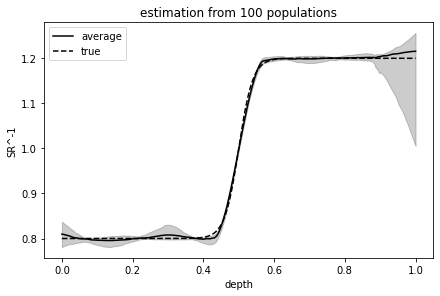

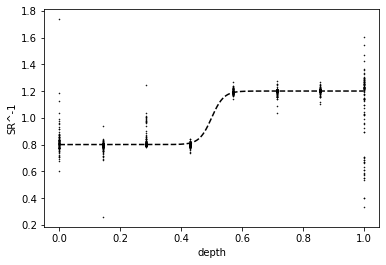

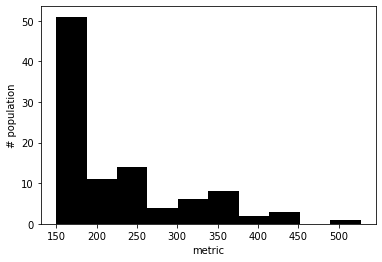

In [356]:
metric_last = np.array([metric_para[i][-1] for i in range(100)])
metric_best = metric_last.min(axis=1)
# invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1,np.argmin(metric_last[i])]], depth) for i, invSR_all in enumerate(invSR_all_para)])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<300]

invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.25, 0.75],axis=0)

fig = plt.figure(constrained_layout=True)
plt.title("estimation from 100 populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="black", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
plt.savefig("figures/invSR_all_populations_sigmoid_akima.png", dpi=200)

plt.figure() 
[plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
plt.plot(depth, invSR, "--", color="black")
plt.xlabel("depth")
plt.ylabel("SR^-1")

plt.figure() 
plt.hist(metric_best, color="black")
plt.xlabel("metric")
plt.ylabel("# population")



Sine

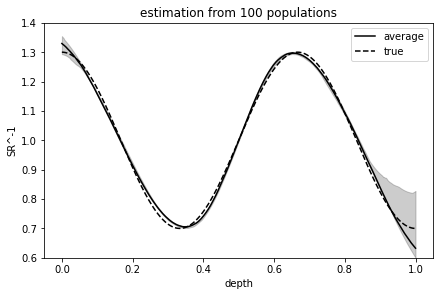

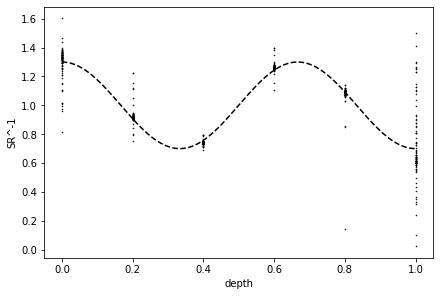

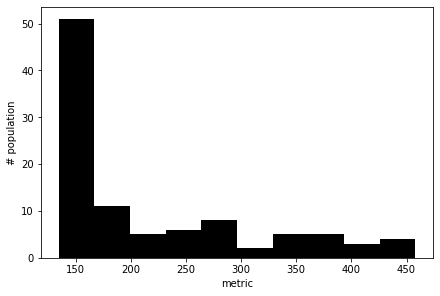

In [381]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
fig.axes[0].set_ylim([0.6,1.4])
# fig.savefig("figures/invSR_all_populations_sine.png", dpi=200)


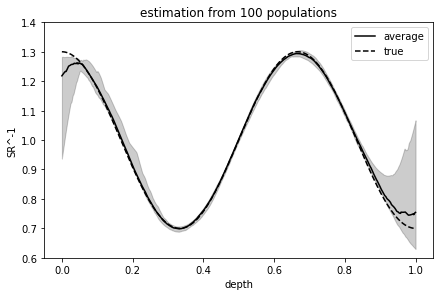

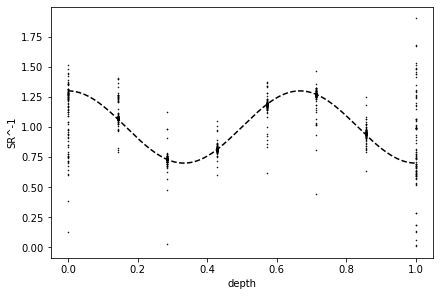

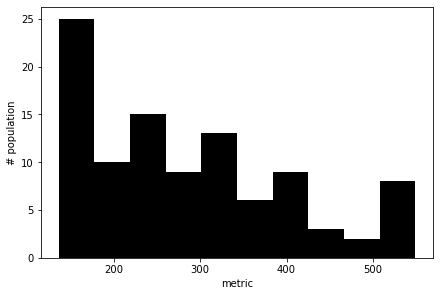

In [435]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
fig.axes[0].set_ylim([0.6,1.4])
fig.savefig("figures/invSR_all_populations_sinek3.png", dpi=200)


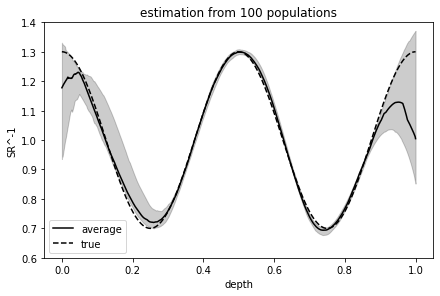

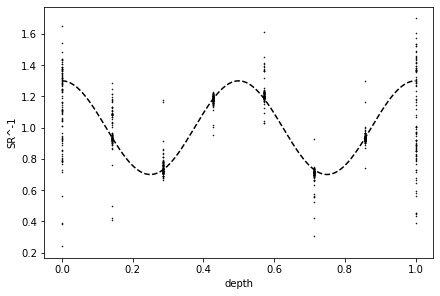

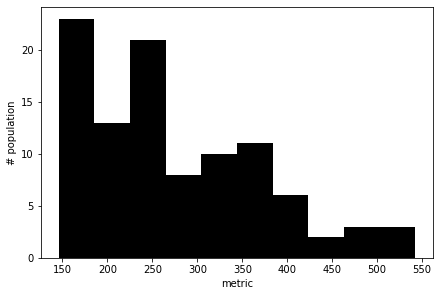

In [443]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
fig.axes[0].set_ylim([0.6,1.4])
fig.savefig("figures/invSR_all_populations_sinek4.png", dpi=200)


Text(0, 0.5, 'SR^-1')

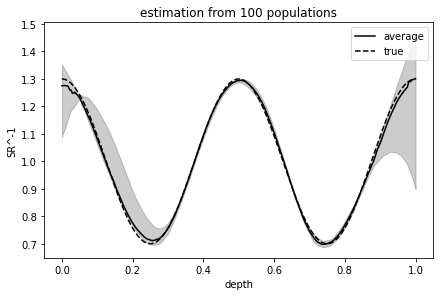

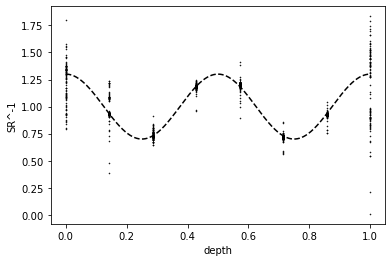

In [189]:
invSR_interpolate_par = np.array([interpolator([depth_grid, invSR_all[-1][0]], depth) for invSR_all in invSR_all_para])
invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.25, 0.75],axis=0)

fig = plt.figure(constrained_layout=True)
plt.title("estimation from 100 populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, invSR, "--", color="black", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
# plt.savefig("figures/invSR_all_populations_line.png", dpi=200)

plt.figure() 
[plt.scatter(depth_grid, invSRi, s=0.3, color="black") for invSRi in invSR_par];
plt.plot(depth, invSR, "--", color="black")
plt.xlabel("depth")
plt.ylabel("SR^-1")
# plt.figure()
# plt.plot(depth, invSR, zorder=1000)
# for i in range(10):
#     # plt.plot(depth_grid, invSR_all_para[i][-1][0], '.')
#     plt.plot(depth, invSR_interpolate_par[i])


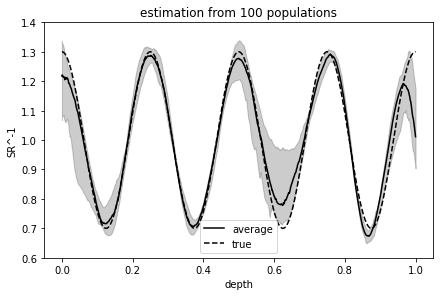

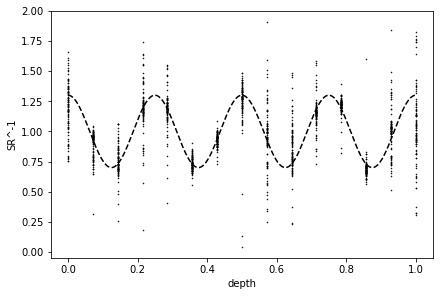

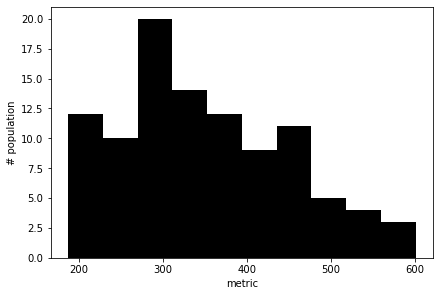

In [421]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
fig.axes[0].set_ylim([0.6,1.4])
fig.savefig("figures/invSR_all_populations_sinek8.png", dpi=200)


Heart wave

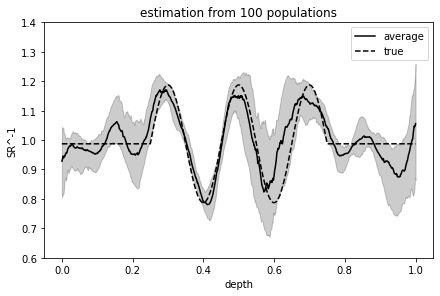

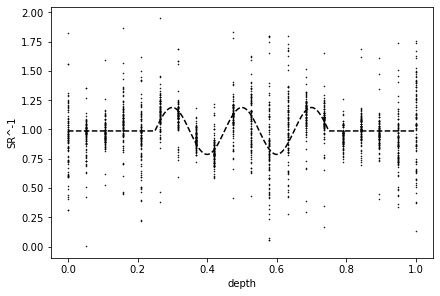

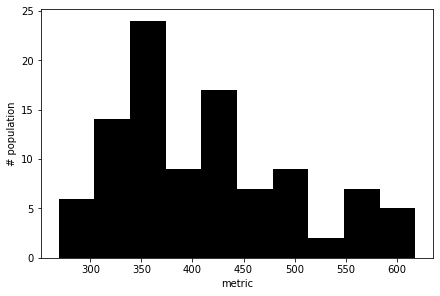

In [456]:
fig, _, _ = plot_MPGA(invSR_all_para, metric_para)
fig.axes[0].set_ylim([0.6,1.4])
# fig.savefig("figures/invSR_all_populations_heartwave.png", dpi=200)
